<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/Mac_effnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU and version**

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cef4eddb-549f-4c6b-9ae7-69d41a1e1323)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


Mount to personal drive

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


Import library

In [4]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

get path

In [6]:
data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo_4class')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1', 'class2', 'class3', 'class4']


In [7]:
class1_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1'
class2_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2'
class3_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3'
class4_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class'

In [ ]:
class1_images = len(os.listdir(class1_dir))
class2_images = len(os.listdir(class2_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class2 images: {class2_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 195
Number of class2 images: 315
Number of class3 images: 201
Number of class4 images: 220


In [14]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1./255,
                              validation_split = 0.3,
                              rotation_range = 40, 
                              horizontal_flip = True, 
                              width_shift_range = 0.2, 
                              height_shift_range = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (240, 240), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (240, 240), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 632 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [15]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(632, 632, (240, 240, 3))

In [16]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(269, 269, (240, 240, 3))

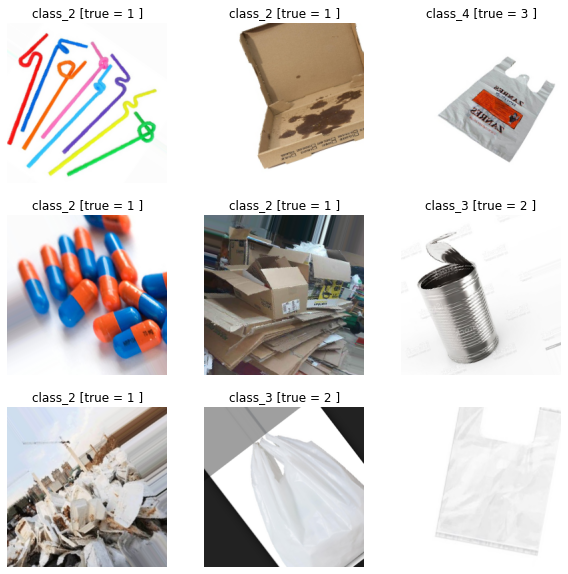

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]")
  plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i])
  #  plt.tight_layout()
  plt.axis("off")

## Tranfer learning (original)

In [8]:
effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape= None ,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)

33583592/33583592 [==============================] - 1s 0us/step


Delete last layer

In [9]:
from keras.models import Model
effnet_v2= Model(inputs=effnet_v2.input, outputs=effnet_v2.layers[-2].output)

In [10]:
effnet_v2.trainable = False

for i,layer in enumerate(effnet_v2.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = rescaling , trainable = False
Layer 2: name = normalization , trainable = False
Layer 3: name = stem_conv , trainable = False
Layer 4: name = stem_bn , trainable = False
Layer 5: name = stem_activation , trainable = False
Layer 6: name = block1a_project_conv , trainable = False
Layer 7: name = block1a_project_bn , trainable = False
Layer 8: name = block1a_project_activation , trainable = False
Layer 9: name = block1b_project_conv , trainable = False
Layer 10: name = block1b_project_bn , trainable = False
Layer 11: name = block1b_project_activation , trainable = False
Layer 12: name = block1b_drop , trainable = False
Layer 13: name = block1b_add , trainable = False
Layer 14: name = block2a_expand_conv , trainable = False
Layer 15: name = block2a_expand_bn , trainable = False
Layer 16: name = block2a_expand_activation , trainable = False
Layer 17: name = block2a_project_conv , trainable = False
Layer 18: name = block2a_project_b

In [11]:
x = effnet_v2.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 120, 120, 32  864         ['normalization[0][0]']    

In [ ]:
tf.keras.utils.plot_model(model, to_file='effnet_org.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)


In [ ]:
# import cv2

# x_train = cv2.resize(x_train,(240,240))
# x_train = x_train.reshape(1,240,240,3)
# print(len(x_train), x_train.shape)
# print(len(y_train), y_train.shape)

compile model

In [12]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

In [17]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.4108 - acc: 0.2851
Epoch 1: val_acc improved from -inf to 0.24211, saving model to weights.hdf5
45/45 [==============================] - 19s 102ms/step - loss: 1.4108 - acc: 0.2851 - val_loss: 1.4256 - val_acc: 0.2421
Epoch 2/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4202 - acc: 0.2628
Epoch 2: val_acc improved from 0.24211 to 0.29474, saving model to weights.hdf5
45/45 [==============================] - 2s 55ms/step - loss: 1.4182 - acc: 0.2624 - val_loss: 1.4051 - val_acc: 0.2947
Epoch 3/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4241 - acc: 0.2628
Epoch 3: val_acc improved from 0.29474 to 0.34737, saving model to weights.hdf5
45/45 [==============================] - 2s 53ms/step - loss: 1.4255 - acc: 0.2624 - val_loss: 1.4257 - val_acc: 0.3474
Epoch 4/30
43/45 [===========================>..] - ETA: 0s - loss: 1.4122 - acc: 0.2860
Epoch 4: val_acc did not improve from 0.34737

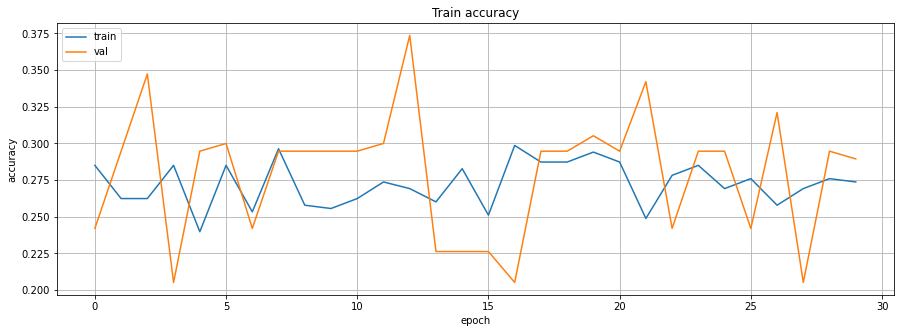

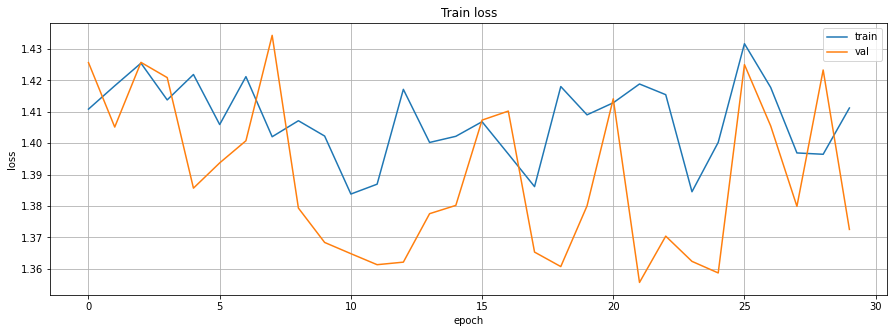

In [18]:
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

In [19]:
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 3s 124ms/step - loss: 1.3786 - acc: 0.3532
['loss', 'acc']: [1.3785761594772339, 0.3531598448753357]
Duration: 0:00:03.645900


Without seed 

In [ ]:

effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(weights = "imagenet", include_top=True)
effnet_v2= Model(inputs=effnet_v2.input, outputs=effnet_v2.layers[-2].output)
effnet_v2.trainable = False

# add classifier
x = effnet_v2.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

#train model without seed
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)
history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
45/46 [============================>.] - ETA: 0s - loss: 1.4089 - acc: 0.3000
Epoch 1: val_acc improved from -inf to 0.34184, saving model to weights.hdf5
46/46 [==============================] - 12s 98ms/step - loss: 1.4082 - acc: 0.3004 - val_loss: 1.3916 - val_acc: 0.3418
Epoch 2/10
45/46 [============================>.] - ETA: 0s - loss: 1.4081 - acc: 0.3044
Epoch 2: val_acc did not improve from 0.34184
46/46 [==============================] - 2s 43ms/step - loss: 1.4088 - acc: 0.3026 - val_loss: 1.4025 - val_acc: 0.3418
Epoch 3/10
45/46 [============================>.] - ETA: 0s - loss: 1.4188 - acc: 0.2911
Epoch 3: val_acc did not improve from 0.34184
46/46 [==============================] - 2s 42ms/step - loss: 1.4175 - acc: 0.2939 - val_loss: 1.3977 - val_acc: 0.3418
Epoch 4/10
45/46 [============================>.] - ETA: 0s - loss: 1.3974 - acc: 0.2711
Epoch 4: val_acc did not improve from 0.34184
46/46 [==============================] - 2s 42ms/step - loss: 1.3972

# Fine tuning


In [20]:
img_w,img_h = 240,240
effnet_v2 = effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape= (img_w, img_h, 3) ,
    pooling="max",
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)
effnet_v2.trainable = True

28456008/28456008 [==============================] - 1s 0us/step


In [ ]:
effnet_v2.summary()

In [ ]:
print("Number of layers in the base model: ", len(effnet_v2.layers))
fine_tune_at = 300
for layer in effnet_v2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  335


In [ ]:
for i,layer in enumerate(effnet_v2.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

In [21]:
x = effnet_v2.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8192, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

In [22]:
opt = tf.keras.optimizers.Adamax(learning_rate = 0.001)
model.compile( loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])

In [23]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=2, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30

Epoch 1: val_acc improved from -inf to 0.20526, saving model to weights.hdf5
45/45 - 25s - loss: 10.3582 - acc: 0.2919 - val_loss: 1.4158 - val_acc: 0.2053 - 25s/epoch - 560ms/step
Epoch 2/30

Epoch 2: val_acc improved from 0.20526 to 0.41053, saving model to weights.hdf5
45/45 - 7s - loss: 1.2564 - acc: 0.4502 - val_loss: 1.1838 - val_acc: 0.4105 - 7s/epoch - 148ms/step
Epoch 3/30

Epoch 3: val_acc improved from 0.41053 to 0.54737, saving model to weights.hdf5
45/45 - 7s - loss: 1.0702 - acc: 0.4864 - val_loss: 0.9622 - val_acc: 0.5474 - 7s/epoch - 147ms/step
Epoch 4/30

Epoch 4: val_acc improved from 0.54737 to 0.56316, saving model to weights.hdf5
45/45 - 7s - loss: 0.9558 - acc: 0.5905 - val_loss: 0.9976 - val_acc: 0.5632 - 7s/epoch - 148ms/step
Epoch 5/30

Epoch 5: val_acc improved from 0.56316 to 0.71579, saving model to weights.hdf5
45/45 - 7s - loss: 0.7914 - acc: 0.6742 - val_loss: 0.7605 - val_acc: 0.7158 - 7s/epoch - 145ms/step
Epoch 6/30

Epoch 6: val_acc did no

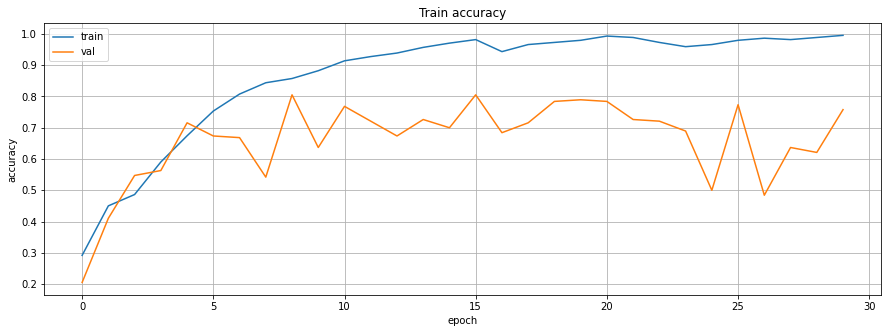

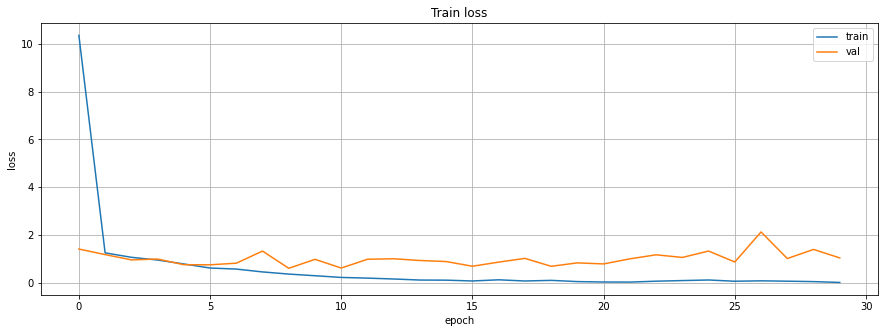

In [24]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

In [25]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 3s 81ms/step - loss: 0.9992 - acc: 0.6691
['loss', 'acc']: [0.9992200136184692, 0.6691449880599976]
Duration: 0:00:03.201547


Without seed

In [26]:
# create model
img_w,img_h = 240,240
effnet_v2 = effnet_v2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(
    weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
effnet_v2.trainable = True
fine_tune_at = 300
for layer in effnet_v2.layers[:fine_tune_at]:
  layer.trainable = False

x = effnet_v2.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(8192, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=effnet_v2.inputs, outputs=new_outputs)

#train model without seed
opt = tf.keras.optimizers.Adamax(learning_rate = 0.001)
model.compile( loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"])

start_time = datetime.now()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=30, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/30


ResourceExhaustedError: ignored

In [ ]:
#Predict

y_pred = model.predict(x_test)
print(y_pred.shape)

9/9 [==============================] - 3s 88ms/step
(278, 4)


In [ ]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [ ]:
y_test[0:10]

array([1., 1., 1., 2., 3., 3., 3., 0., 0., 0.], dtype=float32)

In [ ]:
lst[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
#check error
y_test = y_test.astype(int)
df = pd.DataFrame(list(zip(y_test, lst)), columns = ['y_test', 'y_pred'])
print(df.head())

   y_test  y_pred
0       1       1
1       1       1
2       1       1
3       2       1
4       3       1
